In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
_image_dir = '../datasets/celeba/img_align_celeba_png/'
_img_width = 128
_img_height = 128
_batch_size = 128
_num_epochs = 50

In [3]:
img_df = pd.read_csv('../datasets/celeba/attributes/attr_celeba.csv').replace({-1:0})
partition_df = pd.read_csv('../datasets/celeba/attributes/list_eval_partition.csv')
img_df = img_df.merge(partition_df, on='filename')
img_df.loc[:, 'filename'] = img_df.loc[:, 'filename'].apply(lambda x: os.path.join(_image_dir, x))
img_df.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition
0,../datasets/celeba/img_align_celeba_png/000001...,0,1,1,0,0,0,0,0,0,...,1,1,0,1,0,1,0,0,1,0
1,../datasets/celeba/img_align_celeba_png/000002...,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,../datasets/celeba/img_align_celeba_png/000003...,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,../datasets/celeba/img_align_celeba_png/000004...,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,0
4,../datasets/celeba/img_align_celeba_png/000005...,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [4]:
attributes = np.array(img_df.columns)[1:41]
attributes

array(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'], dtype=object)

In [5]:
train_df = img_df.loc[img_df.loc[:, 'partition'] == 0]
valid_df = img_df.loc[img_df.loc[:, 'partition'] == 1]
test_df = img_df.loc[img_df.loc[:, 'partition'] == 2]

In [6]:
train_datagen =  ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     brightness_range=[0.4,1.5],
    preprocessing_function=preprocess_input,
    rescale=1./255,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    batch_size=_batch_size,
    x_col='filename', 
    y_col= attributes,
    class_mode='raw',
    target_size=(_img_width, _img_height),
    validate_filenames=False)

Found 162770 non-validated image filenames.


In [7]:
valid_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    batch_size=_batch_size,
    x_col='filename', 
    y_col=attributes,
    class_mode='raw',
    target_size=(_img_width, _img_height),
    validate_filenames=False)

Found 19867 non-validated image filenames.


In [8]:
base_model = MobileNet(weights='imagenet',
                       include_top=False,
                       alpha=1, 
                       depth_multiplier=1,
                       dropout=0.001,
                       input_tensor=None, 
                       pooling=None,
                       input_shape=(_img_width, _img_height, 3))

print("number of layers:", len(base_model.layers))

for layer in base_model.layers:
    layer.trainable = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
number of layers: 87


In [9]:
x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dense(256, activation="relu")(x)
x = Dense(40, activation="sigmoid")(x)

In [16]:
model = keras.models.Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
checkpointer = ModelCheckpoint(filepath='mobilenet_allattr.h5', verbose=1, save_best_only=True)

In [18]:
hist = model.fit_generator(train_generator,
                            validation_data = valid_generator,
                            steps_per_epoch= len(train_df)//_batch_size,
                            validation_steps=len(valid_df) // _batch_size,
                            epochs= _num_epochs,
                            callbacks=[checkpointer],
                            verbose=1,
                           )

Epoch 1/50
1271/1271 [==============================] - 340s 268ms/step - loss: 0.2819 - accuracy: 0.8752 - val_loss: 0.4764 - val_accuracy: 0.7893

Epoch 00001: val_loss improved from inf to 0.47641, saving model to mobilenet_allattr.h5
Epoch 2/50
1271/1271 [==============================] - 343s 270ms/step - loss: 0.2631 - accuracy: 0.8831 - val_loss: 0.4887 - val_accuracy: 0.7900

Epoch 00002: val_loss did not improve from 0.47641
Epoch 3/50
1271/1271 [==============================] - 329s 259ms/step - loss: 0.2582 - accuracy: 0.8853 - val_loss: 0.4774 - val_accuracy: 0.7893

Epoch 00003: val_loss did not improve from 0.47641
Epoch 4/50
1271/1271 [==============================] - 332s 262ms/step - loss: 0.2549 - accuracy: 0.8869 - val_loss: 0.4665 - val_accuracy: 0.7893

Epoch 00004: val_loss improved from 0.47641 to 0.46651, saving model to mobilenet_allattr.h5
Epoch 5/50
1271/1271 [==============================] - 328s 258ms/step - loss: 0.2526 - accuracy: 0.8879 - val_loss: 0.

1271/1271 [==============================] - 321s 252ms/step - loss: 0.2335 - accuracy: 0.8967 - val_loss: 0.7014 - val_accuracy: 0.7896

Epoch 00041: val_loss did not improve from 0.46640
Epoch 42/50
1271/1271 [==============================] - 333s 262ms/step - loss: 0.2331 - accuracy: 0.8969 - val_loss: 0.7390 - val_accuracy: 0.7893

Epoch 00042: val_loss did not improve from 0.46640
Epoch 43/50
1271/1271 [==============================] - 317s 250ms/step - loss: 0.2330 - accuracy: 0.8969 - val_loss: 0.6851 - val_accuracy: 0.7893

Epoch 00043: val_loss did not improve from 0.46640
Epoch 44/50
1271/1271 [==============================] - 317s 249ms/step - loss: 0.2329 - accuracy: 0.8970 - val_loss: 0.6746 - val_accuracy: 0.7890

Epoch 00044: val_loss did not improve from 0.46640
Epoch 45/50
1271/1271 [==============================] - 327s 257ms/step - loss: 0.2327 - accuracy: 0.8971 - val_loss: 0.6900 - val_accuracy: 0.7904

Epoch 00045: val_loss did not improve from 0.46640
Epoch 4

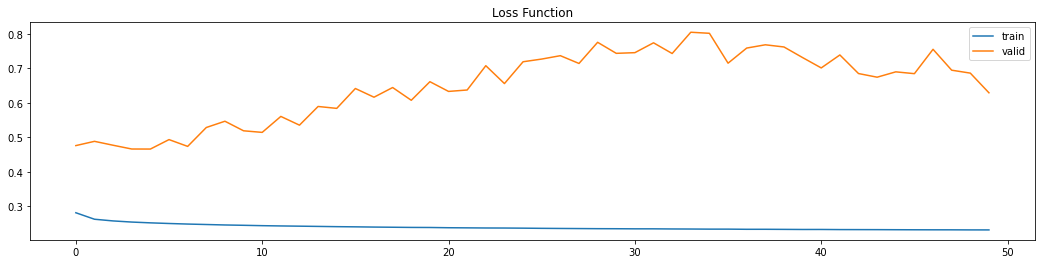

In [19]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

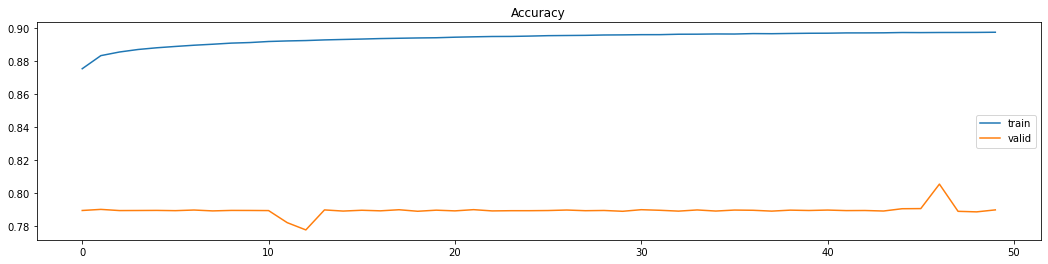

In [20]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [22]:
test_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    batch_size=1,
    x_col='filename', 
    y_col=attributes,
    class_mode='raw',
    target_size=(_img_width, _img_height),
    validate_filenames=False,
    shuffle=False)

Found 19962 non-validated image filenames.


In [23]:
model.load_weights('mobilenet_allattr.h5')
model_predictions = model.predict(test_generator)

In [24]:
preds = np.array(model_predictions > 0.5).astype(int)

In [31]:
test_accuracy = 100 * accuracy_score(preds, test_df.loc[:, attributes].values)
test_accuracy

0.0050095180843602845

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets